In [124]:
# Stdlib
import sys
import random

# Scientific computing
import numpy as np
from node2vec import Node2Vec as N2V

# Network science
import networkx as nx

# Data handling and vis
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Project source
sys.path.append("../../src/")
import synthetic
import utils

# Miscellaneous
from tqdm.auto import tqdm

# Experiment

## Preface

**Goal**

Explore fundamental differences in link prediction and multiplex reconstruction setting on uncorrelated ring topologies.

**Procedure**

1. Generate a ring network, $G$.
2. Create a deepcopy of $G$, $H$, and shuffle the node labels of $H$.
3. Aggregate $G, H$; call it $A$
4. Observe some partial observations from $A$; call them $\theta_G, \theta_H$
5. Calculate the remnants; $R_G = A - \theta_H, R_H = A - \theta_G$
6. Embed $R_G, R_H$; call them $E_G, E_H$
7. Select some edge, $e = (i,j) \in A$
8. Calculate $d_G = d_{E_G}(i, j), d_H = d_{E_H}(i, j)$
9. Repeat (7), (8) for all edges $e \in A$
10. Examine resultant distribution of $d$

## Prerequisite code

In [125]:
def generate_ring_duplex(number_of_nodes):
    """
    Generate a duplex of rings with one layer having shuffled node labels of the other.
    """
    # Create one layer, a ring network
    G = nx.cycle_graph(number_of_nodes)

    # Independent shallow copy the layer
    # * Note that node and edge attributes may have correlations - for this experiment, does not matter but it may in the future
    H = G.copy()

    # Shuffle H's nodes
    new_labels = list(H.nodes())
    random.shuffle(new_labels)  # ^ Why is there such a mix of in-place functions and not :,(
    relabeling_mapping = {node: new_labels[node] for node in range(H.number_of_nodes())}
    H = nx.relabel_nodes(H, relabeling_mapping)

    # ? Do I need to remove any still existing overlap? That would cause disconnectedness necessarily (if overlap is present)

    return G, H

In [126]:
def get_representation(G, params):
    """
    Embed a monoplex with node2vec. Wrapper from @Minsuk Kim.
    """
    # Unpack parameters
    dimensions, walk_length, num_walks, workers,\
    window, min_count, batch_words = params

    # Create node2vec model
    n2v = N2V(G,
        dimensions = dimensions,
        walk_length = walk_length,
        num_walks = num_walks,
        workers = workers,
        quiet = True,
    )

    # Embed topology under specified n2v model
    embedding = n2v.fit(window = window,
        min_count = min_count,
        batch_words = batch_words,
    )

    # Format resultant vectors
    # * Output format: Array with row [i] corresponding to embedded vector of node i
    representation = np.array([
        embedding.wv['%d'%i]
        for i in range(G.number_of_nodes())
    ])

    return representation

In [127]:
def calculate_distances(edge, E_G, E_H):
    # Retrieve nodes incident to edge
    i, j = edge

    # Calculate distance between incident nodes in both embeddings
    d_G = np.linalg.norm(E_G[i] - E_G[j])
    d_H = np.linalg.norm(E_H[i] - E_H[j])

    return d_G, d_H

## Workflow

In [128]:
# * Experiment Parameters
# >>> Network topology <<<
N = 100  # size of rings

# >>> Node2Vec embedding <<<
dimensions = 100  # euclidean dimension to embedd
walk_length = 30  # number of nodes in each walk
num_walks = 100  # number of walks per node
workers = 10  # for cpu parallel work
window = 10  # maximum distance between the current and predicted word within a sentence.
min_count = 1  # ignores all words with total frequency lower than this
batch_words = 4  # [unsure]
params = [dimensions, walk_length, num_walks, workers, window, min_count, batch_words]

# >>> Other <<<
repeat = 100  # number of simulations

In [129]:
# * Steps (1), (2) - Get desired duplex
G, H = generate_ring_duplex(100)

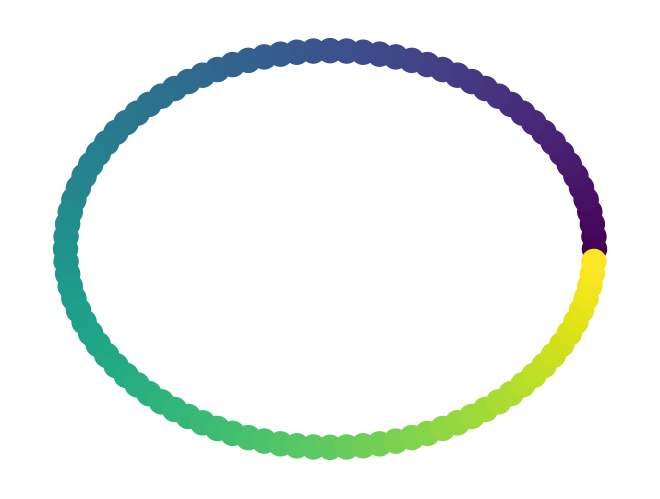

In [130]:
nx.draw(G, node_color=range(N), pos=nx.circular_layout(G))

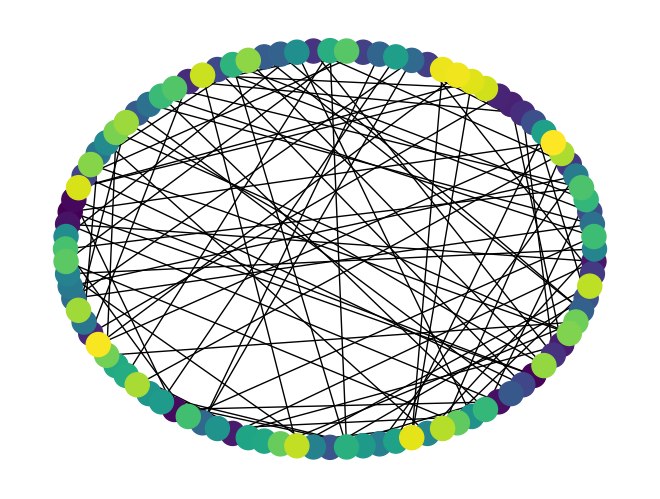

In [131]:
nx.draw(H, node_color=range(N), pos=nx.circular_layout(G))

### Single $\theta$

In [132]:
theta = 0.25

In [133]:
# * Steps (3) thru (5) - Observe a priori information and calculate remnants
R_G, R_H, A = utils.partial_information(G, H, theta)

In [134]:
# * Step (6) - Embed remnants
E_G = get_representation(R_G, params)
E_H = get_representation(R_H, params)

In [135]:
# * Steps (7) thru (9) - Calculate distances of nodes incident to edges in both embeddings
distances_single = {}
for edge in tqdm(A.keys()):
    d = calculate_distances(edge, E_G, E_H)
    distances_single[edge] = d

100%|██████████| 149/149 [00:00<00:00, 29467.71it/s]


### Multiple $\theta$

In [136]:
delta_theta = 0.1
theta_start = 0.05
theta_end = 0.95
thetas = np.arange(theta_start, theta_end + delta_theta, step=delta_theta)  # partial fraction of information
distances_sweep = {}

for theta in tqdm(thetas):
    # * Steps (3) thru (5) - Observe a priori information and calculate remnants
    R_G, R_H, A = utils.partial_information(G, H, theta)

    # * Step (6) - Embed remnants
    E_G = get_representation(R_G, params)
    E_H = get_representation(R_H, params)

    # * Steps (7) thru (9) - Calculate distances of nodes incident to edges in both embeddings
    distances = {}
    for edge in A.keys():
        d = calculate_distances(edge, E_G, E_H)
        distances[edge] = d

    distances_sweep[theta] = distances

100%|██████████| 10/10 [06:40<00:00, 40.02s/it]


## Analysis

### Processing and cleanup

In [137]:
# Single theta
d_G = [d[0] for d in distances_single.values()]
d_H = [d[1] for d in distances_single.values()]

In [138]:
# Multiple theta
records = []
for theta, distances in distances_sweep.items():
    for edge, d in distances.items():
        record = {
            "theta": theta,
            "d_G": d[0],
            "d_H": d[1],
            "edge": edge
        }
        records.append(record)

df = pd.DataFrame.from_records(records)

df = pd.melt(df, id_vars=["theta", "edge"], value_vars=["d_G", "d_H"], var_name="layer", value_name="distance")

### Visualizations

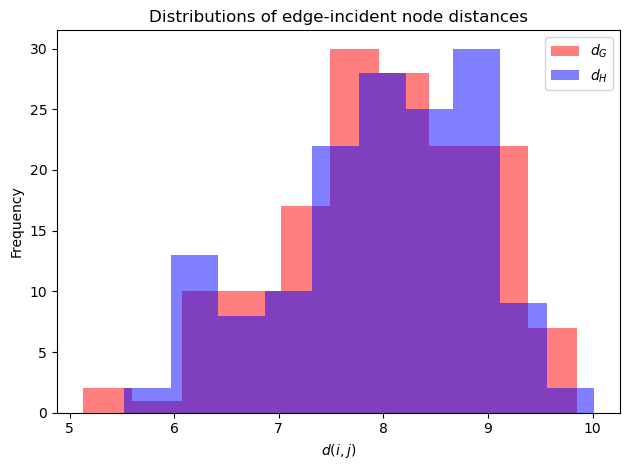

In [139]:
plt.figure()

plt.hist(d_G, label="$d_G$", color="red", alpha=0.5)
plt.hist(d_H, label="$d_H$", color="blue", alpha=0.5)

plt.legend()

plt.xlabel("$d(i,j)$")
plt.ylabel("Frequency")
plt.title("Distributions of edge-incident node distances")

plt.tight_layout()

<Figure size 640x480 with 0 Axes>

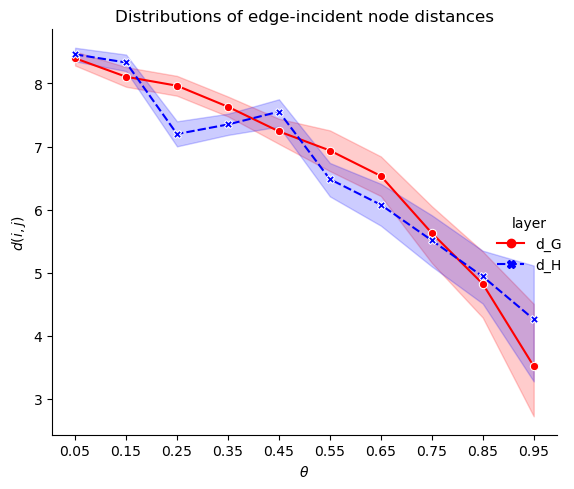

In [140]:
plt.figure()

sns.relplot(
    data=df, kind="line",
    x="theta", y="distance",
    hue="layer", palette=["red", "blue"],
    style="layer",
    markers=True
)

plt.xlabel("$\\theta$")
plt.ylabel("$d(i,j)$")
plt.title("Distributions of edge-incident node distances")

plt.xticks(thetas)

plt.tight_layout()